# APS360 - Classifying Subreddits

Bassam Bibi<br>
Matthew Kwan

## Imports

In [1]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

In [2]:
df = pd.read_csv('./data/removed_b_datav4.csv')
df.head()

,Unnamed: 0,id,subreddit,titles,post,score,url
0,0,1,0,"'New ""Discovery Mode"" turns video game ""Assass...",NaN,53786,https://www.theverge.com/2018/2/20/17033024/as...
1,1,2,0,'We are not here to help you with your End of ...,NaN,38419,https://www.reddit.com/r/history/comments/8pw3...
2,2,3,0,"""A 1776 excerpt from John Adam's diary where h...",NaN,35984,https://founders.archives.gov/documents/Adams/...
3,3,4,0,'Famous Viking warrior burial revealed to be t...,NaN,34919,http://www.news.com.au/technology/science/arch...
4,4,5,0,"""3,000-year-old underwater castle discovered i...",NaN,34196,https://inhabitat.com/3000-year-old-underwater...


In [3]:
def split_post(post):
    # separate punctuations
    post = post.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ") \

    return post.split() # Returns each word as an index in a list


In [4]:
# Download pre-trained glove vectors

glove = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=10000) 

In [44]:
def get_post_words(glove_vector):
    train, valid, test = [], [], []
    for i, line in enumerate(df.post):
        if i%3 == 0:
            if line is np.nan:
                post = df.titles[i]
            else:
                post = line
            
            idxs = [glove_vector.stoi[w]        # lookup the index of word
                    for w in split_post(post)
                    if w in glove_vector.stoi] # keep words that has an embedding
            if not idxs: # ignore posts without any word with an embedding
                continue
            idxs = torch.tensor(idxs) # convert list to pytorch tensor
            label = torch.tensor(df.subreddit[i]).long() #IMPORTANT, need to convert this to numerical category
            if i % 5 < 3:
                train.append((idxs, label))
            elif i % 5 == 4:
                valid.append((idxs, label))
            else:
                test.append((idxs, label))
    return train, valid, test

train,valid,test = get_post_words(glove)

In [45]:
print("Train Length: {} Val Length: {} Test Length: {}".format(len(train),len(valid),len(test)))

Train Length: 2479 Val Length: 828 Test Length: 816


## Batching

In [46]:
import random

class PostBatcher:
    def __init__(self, posts, batch_size=32, drop_last=False):
        # store posts by length
        self.posts_by_length = {}
        for words, label in posts:
            # compute the length of the post
            wlen = words.shape[0]
            # put the posts in the correct key inside self.posts_by_length
            if wlen not in self.posts_by_length:
                self.posts_by_length[wlen] = []
            self.posts_by_length[wlen].append((words, label),)
         
        #  create a DataLoader for each set of posts of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    posts,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, posts in self.posts_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every post length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

In [47]:
train_loader = PostBatcher(train,batch_size=16,drop_last=True)
valid_loader = PostBatcher(train,batch_size=16,drop_last=True)

In [48]:
for i, (posts, labels) in enumerate(train_loader):
    if i > 5: break
    print(posts.shape, labels.shape)

torch.Size([16, 17]) torch.Size([16])
torch.Size([16, 5]) torch.Size([16])
torch.Size([16, 1]) torch.Size([16])
torch.Size([16, 17]) torch.Size([16])
torch.Size([16, 24]) torch.Size([16])
torch.Size([16, 19]) torch.Size([16])


In [49]:
train_loader

## Preliminary Model

In [50]:
class RedditLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=13):
        super(RedditLSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(3, x.size(0), self.hidden_size)
        c0 = torch.zeros(3, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

## Training 

In [58]:
# Function to calculate the accuracy of the results. 
# Returns: # of Correct Predictions / Total # of Predictions

def get_accuracy(model, data_loader, find_loss=False):
  
    criterion = nn.CrossEntropyLoss()

    correct, total = 0, 0
    for posts, labels in data_loader:
        output = model(posts)
        if find_loss == True:
            loss = criterion(output,labels)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
   
    if find_loss == False:
        return correct / total
    else:
        return correct / total,loss

In [59]:
def train_rnn_network(model, train, valid, num_epochs=200, learning_rate=1e-4):
    criterion = nn.CrossEntropyLoss() # Need Cross Entropy for Multi-Classification
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc, val_losses = [], [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for posts, labels in train:
            optimizer.zero_grad()
            pred = model(posts)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        val_acc,val_loss = get_accuracy(model, valid_loader, find_loss=True)
        val_losses.append(val_loss)
        valid_acc.append(val_acc)
        if epoch%50 == 0:
            print("Epoch %d; Train Loss %f; Validation Loss %f; Train Acc %f; Val Acc %f" % (
                  epoch, loss, val_loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 0; Train Loss 2.558999; Validation Loss 2.600181; Train Acc 0.096037; Val Acc 0.092988
Epoch 50; Train Loss 2.136758; Validation Loss 1.412995; Train Acc 0.441311; Val Acc 0.437500
Epoch 100; Train Loss 1.998334; Validation Loss 1.821563; Train Acc 0.558689; Val Acc 0.555640
Epoch 150; Train Loss 0.999956; Validation Loss 1.302524; Train Acc 0.686738; Val Acc 0.685213


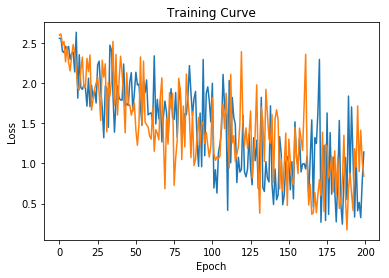

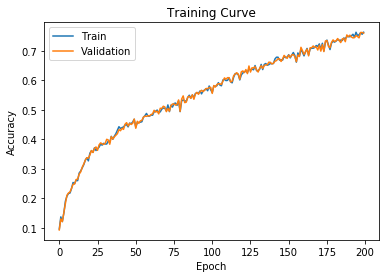

In [61]:
model = RedditLSTM(50,50)
train_rnn_network(model,train_loader,valid_loader)

In [62]:
# Create Test Loader
test_loader = PostBatcher(test,batch_size=16,drop_last=True)

In [63]:
test_acc = get_accuracy(model,test_loader)
print("Our accuracy on our test set was: {}".format(test_acc))

Our accuracy on our test set was: 0.4041666666666667
